# Предсказание стоимости автомобилей марки Ford

Для исследования получен текстовый файл с североамериканскими VIN-кодами машин марки FORD и стоимостью этих автомобилей. 

Единственный источник информации об автомобилях - VIN-код. VIN-код можно декодировать и получить гораздо больше информации, чем просто набор знаков. VIN-код содержит информацию о стране, названии производителя, характеристиках авто (модель, двигатель, тип кузова), типе топлива, годе выпуска и сборочном заводе. Вся эта информация хранится в 17 числовых и буквенных знаках.

Важно, отметить, что символами VIN могут быть заглавные буквы от A до Z и цифры от 1 до 0; однако буквы **I, O и Q** никогда не используются во избежание ошибок при чтении. В VIN не допускается использование знаков или пробелов. Нет двух одинаковых VIN.

**Цель - обучить модель, предсказывающую стоимость автомобилей, основываясь на признаках зашифрованных в VIN-коде.**

Задачи:
1) Подготовка регулярного выражения для парсинга VIN-кода и получить датасет данных
2) EDA
3) Обучение модели
4) Анализ важности признаков
5) Создание класса, предоставляющего инфо об автомобиле и его предсказанную стоимость на основании VIN-кода

## 1. Обзор данных

In [111]:
import pandas as pd
import re 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import Pool, CatBoostRegressor
from sklearn.dummy import DummyRegressor
import shap
from sklearn.inspection import permutation_importance
from io import StringIO
import pickle
RANDOM_STATE = 42

In [112]:
with open('vin_ford_train.txt', 'r', encoding='utf-8') as file:
    vins = file.read()

In [113]:
vin_sample = vins[:107]
vin_sample

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]'

In [114]:
len(vins)

1775058

Один вин-код авто и его стоимость расположены в квадратных скобках. Между вин-кодами может присутствовать какой-то текстовый шум.

## 2. Подготовка датасета

Напишем регулярное выражение для североамериканских вин-кодов машин марки Ford.

In [115]:
# отберем только разрешенные символы - все цифры и  латинские заглавные буквы, кроме I O Q
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [116]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'   #1-3
brake = f'(?P<brake>[{allowed}]{{1}})' #4
model = f'(?P<model>[{allowed}]{{3}})' #5-7
engine = f'(?P<engine>[{allowed}]{{1}})' #8
check = f'(?P<check>[{allowed}]{{1}})' #9
year = f'(?P<year>[{allowed}]{{1}})' #10
plant = f'(?P<plant>[{allowed}]{{1}})' #11
series = f'(?P<series>[{allowed}]{{3}}\\d{{3}})' #12-17
price = f':(?P<price>\d+)' #price

vin = f'({wmi}{brake}{model}{engine}{check}{year}{plant}{series}{price})'
vin_re = re.compile(vin, re.X)
vin_re
# оценим, правильно ли работает RE на небольшом примере
pd.DataFrame([x.groupdict() for x in vin_re.finditer(vin_sample)])

,wmi,brake,model,engine,check,year,plant,series,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200


Регулярное выражение верно разделяет вин-код, поэтому создаем датафрейм.

In [117]:
vin_df = pd.DataFrame([x.groupdict() for x in vin_re.finditer(vins)])

In [118]:
vin_df.sample(5)

,wmi,brake,model,engine,check,year,plant,series,price
6624,1FM,C,U0C,7,0,B,K,C64882,8900
69177,1FA,H,P3K,2,8,C,L,327043,9500
9531,1FA,F,P53,U,3,5,A,250552,1300
65214,1FB,A,X2X,M,X,F,K,A29981,33500
16670,1FA,F,P34,N,0,6,W,226998,2300


In [119]:
vin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   series  71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


In [120]:
vin_df.describe(include='all')

,wmi,brake,model,engine,check,year,plant,series,price
count,71884,71884,71884,71884,71884,71884,71884,71884,71884
unique,14,26,365,32,11,25,21,68215,643
top,1FM,D,P0H,2,1,D,R,B55197,11000
freq,18347,12370,6171,7015,6622,17286,10535,4,574


In [121]:
vin_df.shape

(71884, 9)

Приведем значение цены к числовому типу данных:

In [122]:
vin_df['price'] = vin_df['price'].astype(int)

### Вывод:
- создали регулярное выражение для вычленения характеристик авто из вин-кода
- получили датасет из 9 колонок и 71884 записей

## 3. EDA

Посмотрим на распределение значений признаков и стоимости авто.

Text(0, 0.5, 'Стоимость')

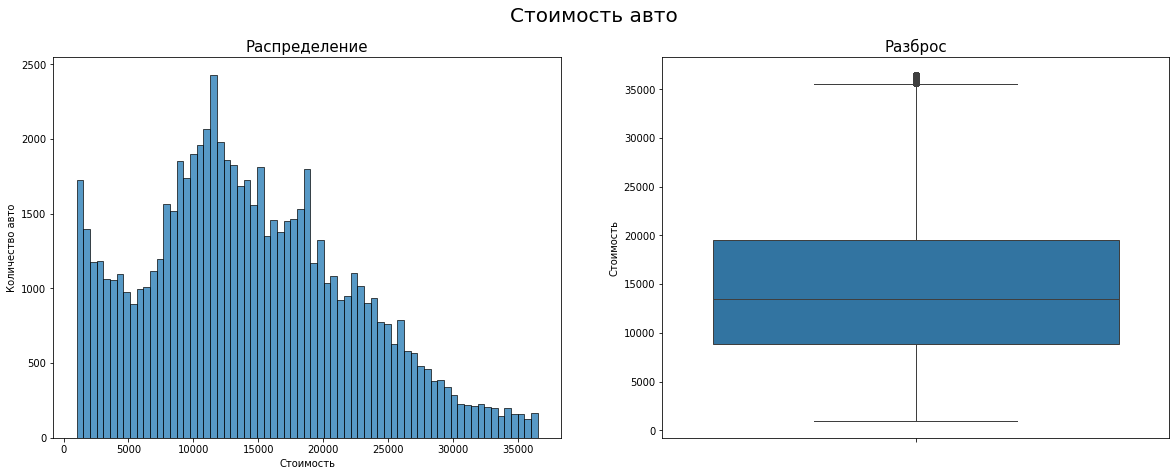

In [123]:
fig, ax = plt.subplots(1,2, figsize = (20,7))
fig.suptitle('Стоимость авто', fontsize = 20)
sns.histplot(x = vin_df['price'], ax = ax[0])
sns.boxplot(vin_df['price'], ax = ax[1])
ax[0].set_title('Распределение', fontsize = 15)
ax[0].set_xlabel('Cтоимость', fontsize = 10)
ax[0].set_ylabel('Количество авто', fontsize = 10)
ax[1].set_title('Разброс', fontsize = 15)
ax[1].set_ylabel('Стоимость', fontsize = 10)



In [124]:
vin_df['price'].describe()

count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64

- Цены авто начинаются от 1 тыс. у.е.
- В среднем авто стоит 9-20 тыс. у.е.
- Есть относительно очень дорогие машины (более 30 тыс. у.е.), их мало


In [125]:
def bar_for_cat(df, cat_cols):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y=0.98)
    for col, ax in zip(cat_cols, axs.ravel()):
        sns.countplot(x = df[col], order = df[col].value_counts().index, hue = df[col], legend=False, ax =ax)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Количество авто', fontsize=12)


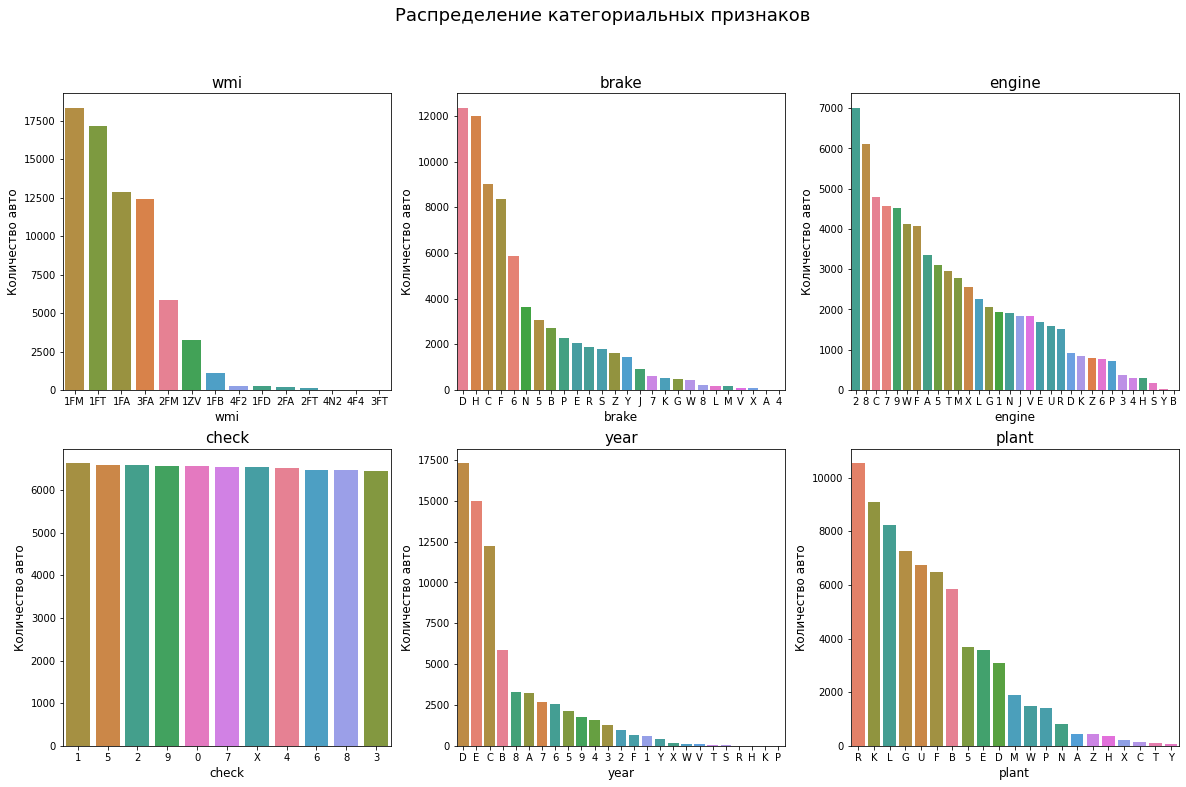

In [126]:
bar_for_cat(vin_df,vin_df.drop(columns=['price', 'series', 'model']).columns)

C:\Users\very-\AppData\Local\Temp\ipykernel_15964\482109466.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\very-\AppData\Local\Temp\ipykernel_15964\482109466.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


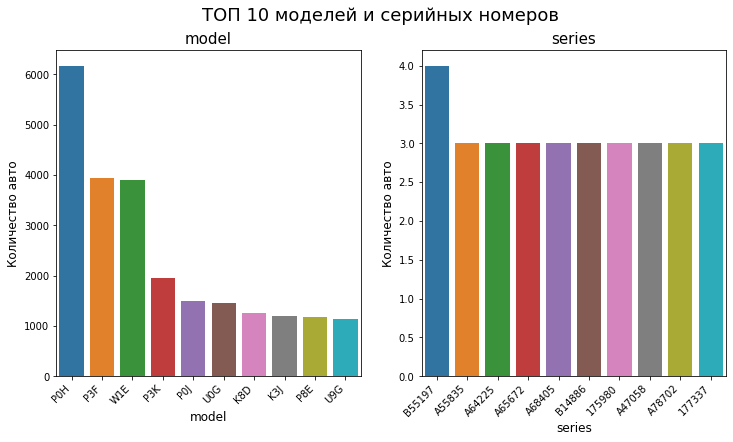

In [127]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('ТОП 10 моделей и серийных номеров' , fontsize=18,  y=0.98)
cols = ['model', 'series']
for col, ax in zip(cols, axs.ravel()):
    top_values = vin_df[col].value_counts().iloc[:10]
    sns.barplot(x=top_values.index, y=top_values.values, hue=top_values.index, legend=False, ax=ax)
    # sns.countplot(x = vin_df[col].value_counts().values[:10], order = vin_df[col].value_counts().index[:10], hue = vin_df[col].value_counts().values[:10], legend=False, ax=ax)
    ax.set_title(col, fontsize=15)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Количество авто', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

Категориальные признаки имеют большое количество подгрупп.
- Серийный номер авто почти уникален
- ТОП-3 wmi 1FM, 1FT, 1FA, расшифровывается как  Ford MPV/SUV, Ford truck, Ford car  - Кроссоверы, грузовики, пассажирские авто марки Форд
- ТОП-3 brake D, H, C. Под этим символами понимаются характеристики тормозной системы,удерживающих устройств. D- Активные ремни безопасности, а также передние и боковые подушки безопасности водителя и пассажира и коленные подушки безопасности со стороны водителя. H - Активные ремни безопасности, а также передние и боковые подушки безопасности водителя и пассажира. C - Активные ремни безопасности, а также передние подушки безопасности
- значения check распределены равномерно
- ТОП-3 year D, E, C: год производства 1983 или 2013, 1984 или 2014 и 1982 или 2012 соотвественно.
- ТОП-3 engine  2, 8, C . Три определенные конфигурации мотора
- ТОП-3 Plant R, K, L: заводы San Jose Assembly (Milpitas, California), Kansas City Assembly (Claycomo, Missouri), Michigan Assembly (Wayne, Michigan)
- ТОП-3 model POH, P3F, W1E : модели Ford Fusion; SE, FWD ('10-'12); Ford Focus, 4-door sedan; SE ('10-'11); Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('10-'23)

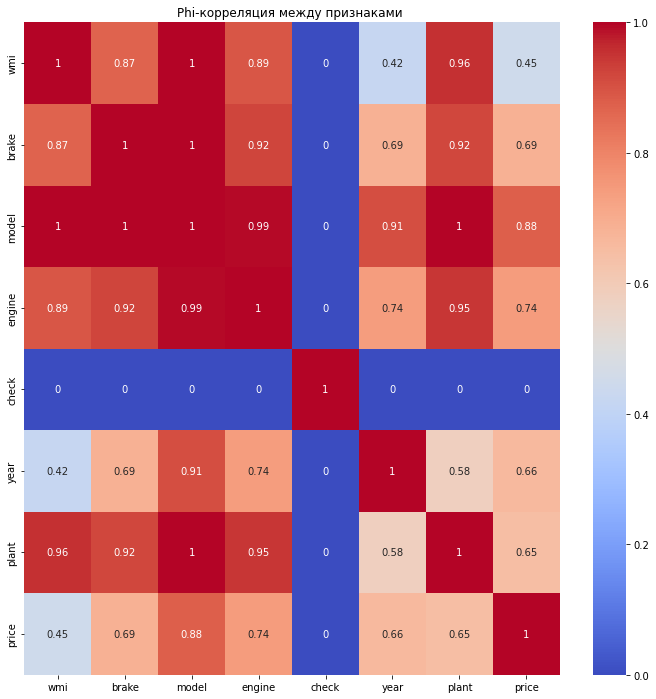

In [128]:
corr_matrix = vin_df.drop(columns=['series']).phik_matrix(interval_cols=['price'],)

plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками ')
plt.show();


- страна и производитель в значительной степени определяют характеристики торомозов и удерживающих устройств. Страна и производитель почти однозначно определяет модель и завод, где  произведено авто. Видимо, определенные модели производились на определенных заводах.
-  модель однозначно определяет характеристики,заложенные в авто, что логично. Год производства 
- Год производства сильно звзаимосвязан с моделью. Так как в разные времена выпускали разные модели.
- Целевой признак - стоимость авто - имеет достаточно сильную зависимость от характеристик машины, года производства.

### Вывод:
- Данные в датасете распределены адекватно
- Цены авто начинаются от 1 тыс. у.е. В среднем авто стоит 9-20 тыс. у.е.
- Целевой признак - стоимость авто - имеет достаточно сильную зависимость от характеристик машины, года производства.

## 4. Обучение модели

- уберем из датасета для обучения признаки `check` и `series`, так как они никак не связан с другими входными признаками и с таргетом.

In [129]:
vin_df_ml = vin_df.drop(columns=['check', 'series', 'price'])
target = vin_df.price

In [130]:
X_train, X_test, y_train, y_test = train_test_split(vin_df_ml, target, test_size=0.2, random_state=RANDOM_STATE)

In [131]:
X_train.shape

(57507, 6)

In [132]:
X_test.shape

(14377, 6)

Сделаем прогноз константой (средним значением), чтобы оценивать адекватность наших реальных моделей:

In [133]:
pipe_dummy = Pipeline(
    [
        ('preprocessor', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ('models', DummyRegressor(strategy='mean'))
    ]
)
pipe_dummy.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 OneHotEncoder(drop='first', handle_unknown='ignore')),
                ('models', DummyRegressor())])

In [134]:
def regression_metrics(y_test, X_test,regressor):
    mae = mean_absolute_error(y_test,regressor.predict(X_test))
    mape = mean_absolute_percentage_error(y_test,regressor.predict(X_test))
    r2 = r2_score(y_test,regressor.predict(X_test))
    rmse = root_mean_squared_error(y_test,regressor.predict(X_test))
    return mae, mape, r2, rmse

mae, mape, r2, rmse = regression_metrics(y_test, X_test,pipe_dummy)
print(f'Dummy model MAE: {mae}')
print(f'Dummy model MAPE: {mape}')
print(f'Dummy model R2: {r2}')
print(f'Dummy model RMSE: {rmse}')

c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as

Dummy model MAE: 6395.046076399706
Dummy model MAPE: 1.0327577818829656
Dummy model R2: -2.556325761893241e-05
Dummy model RMSE: 7854.432285549109


### Catboost

In [135]:
model = CatBoostRegressor(cat_features = list(X_train.columns), 
                          iterations=100,
                          depth=3,
                          silent=True,
                          learning_rate=0.1,
                          loss_function='RMSE', random_state=RANDOM_STATE)


In [136]:
scoring = {'neg_mae':"neg_mean_absolute_error", 
           'neg_mape':"neg_mean_absolute_percentage_error", 
           'r2':"r2", 
           "neg_rmse":"neg_root_mean_squared_error"}
cv_catb =cross_validate(model, X_train, y_train, scoring=scoring)

In [137]:
print(f'MAE при кроссвалидации равна {abs(cv_catb["test_neg_mae"].mean())}')
print(f'MAPE при кроссвалидации равна {abs(cv_catb["test_neg_mape"].mean())}')
print(f'R2 при кроссвалидации равна {abs(cv_catb["test_r2"].mean())}')
print(f'RMSE при кроссвалидации равна {abs(cv_catb["test_neg_rmse"].mean())}')

MAE при кроссвалидации равна 2245.845369108113
MAPE при кроссвалидации равна 0.2449263743226003
R2 при кроссвалидации равна 0.8409709105822089
RMSE при кроссвалидации равна 3118.1714239183852


Наша модель лучше, чем константная, значит она неплохая и полезная для предсказания стоимости авто по харакетристикам внутри вин-кода.

Посмотрим качество на тестовой выборке:

In [138]:
model.fit(X_train, y_train)
mae, mape, r2, rmse = regression_metrics(y_test, X_test,model)
print(f'Метрики на тестовой выборке:')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')
print(f'RMSE: {rmse}')

Метрики на тестовой выборке:
MAE: 2279.033449860695
MAPE: 0.24717360063886365
R2: 0.8373537853484491
RMSE: 3167.6065263620126


In [139]:
#сохраним модель
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

## Вывод:
Для прогнозирования стоимости автомобиля по извлеченным из вин-кода признакам (кроме серийного номера и check digit) обучили градиентный бустинг Catboost (100 итераций, глубина деревьев - 3, скорость обучения - 0.1). Получили адекватное качество (лучше чем у константной модели).

Метрики на тестовой выборке:
- MAE: 2279
- MAPE: 0.25
- R2: 0.84
- RMSE: 3168

# 5. Анализ важности признаков

In [140]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
catboost_importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)

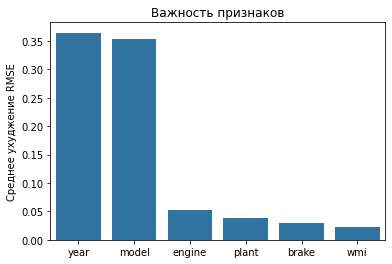

In [141]:
fig = plt.Figure()
sns.barplot(catboost_importances)
plt.title("Важность признаков")
plt.ylabel("Среднее ухуджение RMSE")
fig.tight_layout()
plt.show()

### Вывод:
Наиболее важными признаками, которые влияют на предсказание цены, являются год производства и модель авто.

## 6. Декодирование вин-кодов и создание класса для предоставлния инфо об авто и прогнозирования цены 

Чтобы декодировать вин-коды, нужно достать инфо из табличек https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Printable_version#Model# 

In [144]:
with open(r'parsed_wiki_tables\year.txt', 'r', encoding='utf-8') as file:
    year_table = file.read()

with open(r'parsed_wiki_tables\wmi.txt', 'r', encoding='utf-8') as file:
    wmi_table = file.read()

with open(r'parsed_wiki_tables\brakes.txt', 'r', encoding='utf-8') as file:
    brakes_table = file.read()

with open(r'parsed_wiki_tables\restraints.txt', 'r', encoding='utf-8') as file:
    restraints_table = file.read()

with open(r'parsed_wiki_tables\models_1.txt', 'r', encoding='utf-8') as file:
    models_table_1 = file.read()

with open(r'parsed_wiki_tables\models_2.txt', 'r', encoding='utf-8') as file:
    models_table_2 = file.read()

with open(r'parsed_wiki_tables\engine.txt', 'r', encoding='utf-8') as file:
    engine_table = file.read()

In [145]:
year_table

'A\t1980, 2010\nB\t1981, 2011\nC\t1982, 2012\nD\t1983, 2013\nE\t1984, 2014\nF\t1985, 2015\nG\t1986, 2016\nH\t1987, 2017\nJ\t1988, 2018\nK\t1989, 2019\nL\t1990, 2020\nM\t1991, 2021\nN\t1992, 2022\nP\t1993, 2023\nR\t1994, 2024\nS\t1995, 2025\nT\t1996, 2026\nV\t1997, 2027\nW\t1998, 2028\nX\t1999, 2029\nY\t2000, 2030\n1\t2001, 2031\n2\t2002, 2032\n3\t2003, 2033\n4\t2004, 2034\n5\t2005, 2035\n6\t2006, 2036\n7\t2007, 2037\n8\t2008, 2038\n9\t2009, 2039'

In [146]:
pattern = r'(?P<vin>[A-Z])\t(?P<year>\d{4}),\s(?P<second_year>\d{4})'
compiled_pattern = re.compile(pattern)
year = pd.DataFrame([x.groupdict() for x in compiled_pattern.finditer(year_table)])
year.sample(5)

,vin,year,second_year
9,K,1989,2019
20,Y,2000,2030
3,D,1983,2013
11,M,1991,2021
2,C,1982,2012


In [147]:
wmi = pd.read_html(wmi_table)[0]
brakes = pd.read_html(brakes_table)[0]
restraints = pd.read_html(restraints_table)[0]
engine = pd.read_html(engine_table)[0]

C:\Users\very-\AppData\Local\Temp\ipykernel_15964\1055003168.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  wmi = pd.read_html(wmi_table)[0]
C:\Users\very-\AppData\Local\Temp\ipykernel_15964\1055003168.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  brakes = pd.read_html(brakes_table)[0]
C:\Users\very-\AppData\Local\Temp\ipykernel_15964\1055003168.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  restraints = pd.read_html(restraints_table)[0]
C:\Users\very-\AppData\Local\Temp\ipykernel_15964\1055003168.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future ver

In [148]:
wmi.sample(5)

,WMI,Country,Description,Vehicle types
33,1FD,USA,Ford Motor Company,Ford incomplete vehicle
3,KNJ,South Korea,Ford (made by Kia),NaN
66,3FR,Mexico,Blue Diamond Trucks S. De R. L. De C. V.,Ford incomplete vehicle
39,1ME,USA,Ford Motor Company,Mercury passenger car
26,Z6F,Russia,Ford Sollers,NaN


In [149]:
brakes.sample(5)

,VIN Code,GVWR Range in lbs.,Brake System
20,X,"26,001 – 33,000",Air
18,V,"16,001 – 19,500",Air
19,W,"19,501 – 26,000",Air
13,P,"26,001 – 33,000",Hydraulic
4,E,"6,001 – 7,000",Hydraulic


In [150]:
restraints.sample(5)

,VIN code,Description
12,G,Active Belts plus Driver and Passenger Front A...
6,K,Active Belts and Driver and Passenger (Second ...
4,L,Active Belts and Driver and Passenger (First G...
3,A,Active (Manual) Belt (Driver) & Passive (Motor...
1,P,Passive belts (Motorized)


In [151]:
engine.sample(5)

,Configuration,Name,Displacement,Description,Fuel,Power (hp),Power (kW),VIN code,Notes/Applications
52,I4,2.3 L EcoBoost,2.3L,DOHC 16V DI Turbo,Gasoline,310-315-330-350,228-232-243-257,H,"Ford Mustang EcoBoost 6th gen. ('15-'23), Ford..."
40,I4,Zeta,2.0L,DOHC 16V Intake VCT,Gasoline,170,125,5,Ford Focus SVT ('02-'04)
94,V8,Windsor,"""5.0"" (4.9L)",OHV CFI,Gasoline,130-134-140-145-155-180,96-99-103-107-114-132,F,"Thunderbird, Mercury Cougar, LTD Crown Victori..."
44,I4,Duratec 20,2.0 L,DOHC 16V Intake VCT Atkinson Cycle,Gasoline-Electric Hybrid,141 (gas) + 118 (electric) = 188 (combined),104 (gas) + 88 (electric) = 138 (combined),U,"Ford C-Max Hybrid ('13-'18), Ford Fusion Hybri..."
49,I4,Duratec 25,2.5L,DOHC 16V Intake VCT Atkinson Cycle,Gasoline-Electric Hybrid,156 (gas) + 106 (electric) = 191 (combined),115 (gas) + 78 (electric) = 141 (combined),3,"Ford Fusion Hybrid ('10-'12), Mercury Milan H..."


In [152]:
engine = engine[['VIN code', 'Power (hp)', 'Fuel', ]]

engine.sample(5)

,VIN code,Power (hp),Fuel
28,H,52,Diesel
12,2,65-70,Gasoline
35,C,110,Gasoline
36,L,145,Gasoline
116,S,540,Gasoline


In [153]:
models_1 = pd.read_html(StringIO(models_table_1))[0]

In [154]:
models_1.head()

,VIN Code,Model
0,A11%A14%A15%A21%A24%A25%A31%A34%A35%A41%A44%A45,Ford Aerostar regular length passenger van ('8...
1,A51%A50%A51%A52%A53%A54%A57%A58,Ford Windstar passenger van ('95-'98) % Ford W...
2,A50%A51%A52%A54%A57%A58,Ford Freestar S ('04-'05) % Ford Freestar SE (...
3,A20%A21%A22%A23,Mercury Monterey ('04) % Mercury Monterey; Con...
4,C35%C45%C55,Ford E-350 Chassis Cab ('03-'04) % Ford E-450 ...


In [155]:
v = models_1['VIN Code'].str.split('%').explode()
v.info()

<class 'pandas.core.series.Series'>
Index: 1467 entries, 0 to 202
Series name: VIN Code
Non-Null Count  Dtype 
--------------  ----- 
1467 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [156]:
m = models_1['Model'].str.split('%').explode()

m.info()

<class 'pandas.core.series.Series'>
Index: 1517 entries, 0 to 202
Series name: Model
Non-Null Count  Dtype 
--------------  ----- 
1517 non-null   object
dtypes: object(1)
memory usage: 23.7+ KB


Не совпадает количество строк, видимо, есть пустые строки с пробелом.

In [157]:
m[m==''].shape

(59,)

In [158]:
v[v==''].shape

(9,)

In [159]:
m = m[m!='']
m.shape

(1458,)

In [160]:
v = v[v!='']
v.shape

(1458,)

In [161]:
models_1 = pd.concat([v,m], axis =1)

In [162]:
models_1.sample(5)

,VIN Code,Model
77,P1R,Ford EcoSport; S FWD ('18)
88,P38,"Ford Tempo, 4-door sedan; Sport GL ('87), GLS..."
15,F47,"Ford F-Series, Super Duty F-450, Regular Cab,..."
96,P58,Ford Taurus; SE wagon ('00-'05)
122,P8C,"Ford Mustang, Coupe; GT ('24)"


In [163]:
models_2 = pd.read_html(StringIO(models_table_2))[0]
models_2.sample()

,VIN Code,Model
33,W80%W82%W82%W90,Ford LNT8000 Diesel (Short-nose) (Tandem Axle)...


In [164]:
v = models_2['VIN Code'].str.split('%').explode()
print(v.info())
m = models_2['Model'].str.split('%').explode()

m.info()

<class 'pandas.core.series.Series'>
Index: 217 entries, 0 to 42
Series name: VIN Code
Non-Null Count  Dtype 
--------------  ----- 
217 non-null    object
dtypes: object(1)
memory usage: 3.4+ KB
None
<class 'pandas.core.series.Series'>
Index: 222 entries, 0 to 42
Series name: Model
Non-Null Count  Dtype 
--------------  ----- 
222 non-null    object
dtypes: object(1)
memory usage: 3.5+ KB


In [165]:
print(m[m==''].shape)
print(v[v==''].shape)

(5,)
(0,)


In [166]:
m = m[m!='']
models_2 = pd.concat([v,m], axis =1)
models_2.sample(5)

,VIN Code,Model
11,G70,"Ford P700, Gas, Parcel Stripped Chassis ('95-..."
8,F6B,"Ford F-Series, F-650 Super Duty, Regular Cab,..."
15,K64,"Ford F-Series, F-600, Detroit Diesel 8.2L ""Fu..."
35,X65,"Ford F-Series, F-650 Super Duty, Super Cab, St..."
12,H82,"Ford C series, CT8000, Caterpillar 3208 Diese..."


In [167]:
models = pd.concat([models_1, models_2], axis = 0)
models.shape[0] == models_1.shape[0] + models_2.shape[0]

True

In [168]:
models.sample(3)

,VIN Code,Model
10,F25,"Ford F-Series, F-250, Regular Cab, 2WD ('81-'..."
144,S7F,Ford Transit Connect; XLT Cargo Van LWB w/Swi...
5,E15,"Ford Econoline, E-150 Window Van regular leng..."


In [169]:
year.to_pickle(r'parsed_wiki_tables\year.pkl')
wmi.to_pickle(r'parsed_wiki_tables\wmi.pkl')
models.to_pickle(r'parsed_wiki_tables\models.pkl')
engine.to_pickle(r'parsed_wiki_tables\engine.pkl')
brakes.to_pickle(r'parsed_wiki_tables\brakes.pkl')
restraints.to_pickle(r'parsed_wiki_tables\restraints.pkl')

Создадим класс:

In [170]:
class AutoByVin:
    def __init__(self, vin_code):
        self.vin_code = vin_code
        with open('model.pkl', 'rb') as f:
            self.model_for_pred = pickle.load(f)

        with open(r'parsed_wiki_tables\year.pkl', 'rb') as f:
            self.year = pickle.load(f)

        with open(r'parsed_wiki_tables\wmi.pkl', 'rb') as f:
            self.wmi = pickle.load(f)
        
        with open(r'parsed_wiki_tables\restraints.pkl', 'rb') as f:
            self.restraints = pickle.load(f)

        with open(r'parsed_wiki_tables\models.pkl', 'rb') as f:
            self.models = pickle.load(f)

        with open(r'parsed_wiki_tables\engine.pkl', 'rb') as f:
            self.engine = pickle.load(f)

        with open(r'parsed_wiki_tables\brakes.pkl', 'rb') as f:
            self.brakes = pickle.load(f)
        
    def parse_vin(self):
        allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
        wmi_re = f'(?P<wmi>[{allowed}]{{3}})'   #1-3
        brake_re = f'(?P<brake>[{allowed}]{{1}})' #4
        model_re = f'(?P<model>[{allowed}]{{3}})' #5-7
        engine_re = f'(?P<engine>[{allowed}]{{1}})' #8
        check_re = f'(?P<check>[{allowed}]{{1}})' #9
        year_re = f'(?P<year>[{allowed}]{{1}})' #10
        plant_re = f'(?P<plant>[{allowed}]{{1}})' #11
        series_re = f'(?P<series>[{allowed}]{{3}}\\d{{3}})' #12-17

        #проверка, что это фордовский вин
        


        vin = f'({wmi_re}{brake_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{series_re})'
        vin_re = re.compile(vin, re.X)
        match = vin_re.match(self.vin_code)
        if not match:
            raise ValueError('Невалидный вин-код. Попробуйте еще раз.')
        return pd.DataFrame([x.groupdict() for x in vin_re.finditer(self.vin_code)])

    def get_auto_info(self):
        parsed = self.parse_vin()
        if parsed['wmi'].iloc[0] not in self.wmi['WMI'].unique():
            raise ValueError(f'{self.vin_code} не относится к бренду Ford. Не можем предоставить достоверную информацию.')

        auto_wmi = self.wmi[self.wmi['WMI'] == parsed['wmi'].iloc[0]]
        auto_model = self.models[self.models['VIN Code'] == parsed['model'].iloc[0]]
        auto_engine = self.engine[self.engine['VIN code'] == parsed['engine'].iloc[0]]
        auto_brakes = self.brakes[self.brakes['VIN  Code'] == parsed['brake'].iloc[0]]
        auto_restraints = self.restraints[self.restraints['VIN code'] == parsed['brake'].iloc[0]]


        info =  {
            "model": auto_model.iloc[0]['Model'] if not auto_model.empty else "Unknown",
            "engine": (auto_engine.iloc[0]['Power (hp)'], auto_engine.iloc[0]['Fuel']) if not auto_engine.empty else "Unknown", 
            "country": auto_wmi.iloc[0]['Country'] if not auto_wmi.empty else "Unknown",
            "description": auto_wmi.iloc[0]['Description'] if not auto_wmi.empty else "Unknown",
            "vehicle type": auto_wmi.iloc[0]['Vehicle types'] if not auto_wmi.empty else "Unknown",
            "brakes": auto_brakes.iloc[0]['Brake System'] if not auto_brakes.empty else "Unknown",
            "restraints": auto_restraints.iloc[0]['Description'] if not auto_restraints.empty else "Unknown",

        }
        return f'''Страна производства: {info["country"]}
Описание: {info["description"]}
Тип автомобиля: {info["vehicle type"]}
Модель: {info["model"]}
Характеристик мотора: {info["engine"][0]} лошадиных сил, топливо: {info["engine"][1]}
Тормозная система: {info["brakes"]}
Удерживающие устройства: {info["restraints"]}

'''

    def predict_price(self):
        parsed = self.parse_vin()
        if parsed['wmi'].iloc[0] not in self.wmi['WMI'].unique():
            raise ValueError(f'{self.vin_code} не относится к бренду Ford. Не можем предоставить достоверную информацию.')
        parsed = parsed.drop(columns=['series', 'check'])
        price = self.model_for_pred.predict(parsed)
        return price[0]


In [171]:
auto = AutoByVin("3FA6P0H75ER208976")
print(auto.get_auto_info())
print("Прогнозируемая стоимость, у.е.:", round(auto.predict_price()))

Страна производства: Mexico
Описание: Ford Motor Company (Mexico)
Тип автомобиля: Ford passenger car
Модель:  Ford Fusion; SE, FWD ('10-'12) 
Характеристик мотора: 175 лошадиных сил, топливо: Gasoline
Тормозная система: Unknown
Удерживающие устройства: Active Belts plus Driver and Passenger Front Airbags & Side Airbags (1st & 2nd row) & Driver and Passenger Knee Airbags ('13-)


Прогнозируемая стоимость, у.е.: 14185


# Итоговый вывод работы:
В этом исследовании я создала модель, которая предсказывает стоимость автомобиля марки Ford по составляющим ВИН-кода. 

При подготовки данных для обучения модели я распарсила ВИН-коды в датасет с помощью определенного регулярного выражения, включающего паттерны ВИН-кодов.

В качестве модели использовала градиентный бустинг Catboost (100 итераций, глубина деревьев - 3, скорость обучения - 0.1). Получили адекватное качество (лучше чем у константной модели).

Метрики на тестовой выборке:
- MAE: 2279
- MAPE: 0.25
- R2: 0.84
- RMSE: 3168

Наиболее важными признаками, которые влияют на предсказание цены, оказались год производства и модель авто.

Заключающим этап работы был подготовлен класс, котороый на вход принимает vin-код автомобиля (один) и выдает информацию об автомобиле и предсказанную стоимость.


